# Multiple Correspondence Analysis (MCA)

## Introducción a MCA

### Como el análisis de correspondencia, pero con múltiples variables

El Análisis de Correspondencia Múltiple (MCA) nos permite extender el Análisis de Correspondencia (CA) simple más allá de una tabla cruzada de *dos* variables diferentes en muchas más.

Por ejemplo, un conjunto de datos [bastante utilizado](https://personal.utdallas.edu/~herve/Abdi-MCA2007-pretty.pdf) para describir este método es un perfil de sabor de varios vinos a partir de diferentes expertos.

Como antes, comenzamos con un conjunto de datos con individuos "I" como filas y columnas "J" como características. Sin embargo, en este caso, hay varias respuestas por función. Algunas cosas para señalar en particular:

- Dos expertos diferentes tienen la misma función. Tanto el experto 2 como el 3 tienen una columna `woody` (leñoso). MCA trata estas columnas por separado, pero si existe una relación subyacente entre las dos (como es de esperar), los baricentros de las columnas terminarán cerca uno del otro.
- También hay un par de características (`woody`,` vanillin`) que tienen más de una etiqueta binaria
- Podemos usar `.get _dummies()` en cada característica para obtener la representación de 1-hot, sin embargo, no debemos usar `drop_ first = True`.

<img src="images/mca_data.png" width="700">

También vale la pena señalar que la tabla anterior es una tabla *intermedia* entre "tabla alta con una columna para cada variable (no separada)" y la "tabla cruzada utilizada para hacer CA".

En última instancia, podemos hacer la representación similar de "filas de gráficos" o "columnas de gráficos" que podríamos hacer con CA, solo que esta vez tiene más niveles.

<img src="images/mca_wines.png" width="700">

### Un ejemplo más grande

Ahora exploraremos un conjunto de datos mucho más grande (`n = 8403 >> 6`) que codifica varias características de estilo de vida para una población determinada.

<img src="images/mca_life_data.png" width="700">

MCA explora conceptos similares a CA, incluida la inercia, ponderando cada registro por los valores individuales, etc.

Pero se vuelve particularmente interesante cuando se ajusta a dos ejes y se realiza una gráfica de dispersión que hace la representación de cada persona en este espacio bidimensional, *coloreando según el valor de descriptor* (es decir, según su categoría):

<img src="images/mca_gardening_1.png" width="700">


Esto todavía era completamente posible en CA, simplemente no teníamos suficientes datos para que este patrón se mostrara tan claramente. En cambio, lo que obtuvimos fue una mirada a los baricentros de las columnas dadas, que luego trazó sobre la dispersión en dos triángulos de colores.

De hecho, al hacer esto para todos los baricentros (centros de masa), se descubre que surge un patrón.

Recuerde que todos los datos no estaban organizados como una sola columna `0 / 1`, sino como *dos*  columnas `0 / 1`, por ejemplo:

```
cinema
   0
   1
   1
```
se convierte en

```
cine_yes cinema_no
    0        1
    1        0
    1        0
```

Al examinar con detalle, se encuentra que que los baricentros en negro corresponden a los `_no` y, de manera similar, los rojos a `_yes`.

Es posible que estemos pensando "Bueno, ¿y qué tiene ver eso con los ejes?" y ahí es donde debemos recordar que la C en MCA significa "correspondencia". O para decirlo de otra manera, mirando esta representación, aprendemos que las personas que no hacen una cosa se corresponden altamente con que no hacen otra cosa. Por lo tanto, **podemos pensar en el primer eje como un continuo de apatía**

<img src="images/mca_barycenters.png" width="600">

Esto se hace aún más obvio cuando seleccionamos cuatro individuos en el borde de esta nube de puntos.

<img src="images/mca_apathy.png" width="900">

De manera similar, podemos observar los puntos en las esquinas opuestas, para ver que, el segundo eje está vagamente asociado con la juventud de las personas que realizan los pasatiempos.

<img src="images/mca_youth.png" width="800">

## Implementación de MCA en python (`prince`)

Para ilustrar cómo `prince` hace un trabajo eficiente de` MCA`, usaremos el conjunto de datos Titanic de `seaborn`, ya que tiene una buena cantidad de variables categóricas.

In [3]:
%matplotlib inline

import pandas as pd
import prince
import seaborn as sns

Cargamos el dataset y descartamos cualquier valor nulo para `edad` (para hacer un ejemplo rápido)

In [4]:
data = sns.load_dataset('titanic').dropna(subset=['age'])
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [22]:
data.shape

(714, 16)

Probando con algunos bins, encontramos algunos intervalos que nos dan una buena separación de la edad en nuestros datos.

In [5]:
data['age_bin'] = pd.cut(data['age'],
                         [0, 18, 30, 45, 999])

data['age_bin'].value_counts().sort_index()

(0, 18]      139
(18, 30]     270
(30, 45]     202
(45, 999]    103
Name: age_bin, dtype: int64

Y entonces usaremos este descriptor creado, así como algunas otras variables categóricas, para ver si hay alguna estructura subyacente a nuestros datos.

In [53]:
df = data[['sex', 'embarked', 'class', 'age_bin']]


mca = prince.MCA(n_components=2)
mca.fit(df)

MCA()

Al igual que con CA, hay un buen método `.plot_coordinates()` que podemos usar para examinar la estructura de los "loadings".

Lo primero que llama la atención es la combinación de puntos verdes y azules para el `Componente 0`: el valor "continuo" desde la clase baja a la clase alta para cada pasajero, parece correlacionarse con si esa persona era hombre o no.

Al mirar el "Componente 1", intriga ver que la ciudad en la que se embarcó una persona tenía tal extensión ("Q", "C", "S", en orden descendente). Es decir, hasta que vemos que `age_bin` también lo hizo.

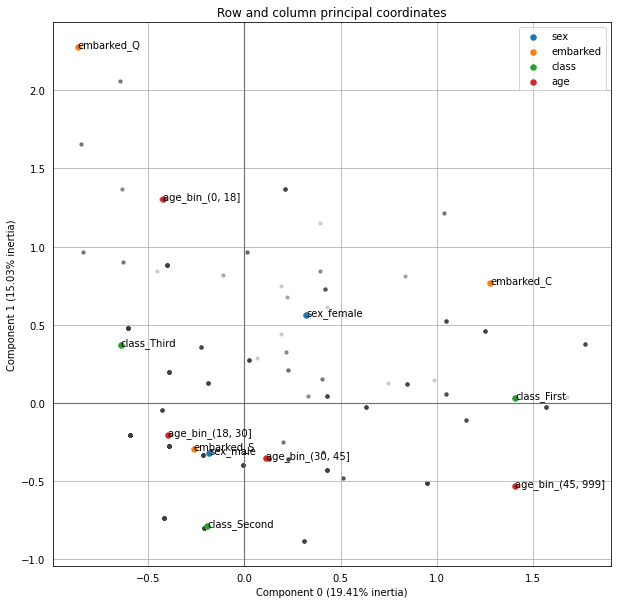

In [24]:
mca.plot_coordinates(df,
                     row_points_alpha=.2,
                     figsize=(10, 10),
                     show_column_labels=True
                    );

De hecho, al observar la distribución de edades por ubicación de embarque de nuestro conjunto de datos original, podemos ver que `Q` tiene la edad media más baja, luego` C`, luego `S`, lo cual es consistente con nuestro orden en la `Componente 1`.

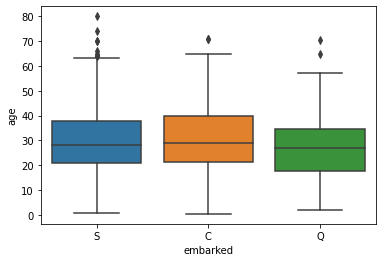

In [9]:
sns.boxplot(data=data, x='embarked', y='age');

In [ ]:
Xs = mca.transform(df)
Xs

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression


In [70]:
pipe = Pipeline([('mca', prince.MCA(n_components=10)), ('LR', LogisticRegression())])

In [71]:
cross_val_score(pipe, df, data.survived.values)

array([0.71328671, 0.81818182, 0.76223776, 0.73426573, 0.82394366])

In [63]:
prince.MCA??

## Referencias

- Greenacre, M., 2017. Correspondence analysis in practice. chapman and hall/crc.
- https://youtu.be/gZ_7WWEVlTg

# Ejercicios

[1] Realice un pipeline que involucre MCA y un clasificador (regresion logística, LDA, etc.) y realice la validación cruzada usando sólo las variables categóricas (`df`) del dataset del Titanic.

[2] Usando un pipeline similar al anterior encuentre el mejor número de componentes principales usando MCA y validación cruzada (puede usar GridSearchCV). Compruebe el mejor modelo en un test set independiente.

[3] Use `sklearn.compose.ColumnTransformer`(ver [este ejemplo](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py)) para realizar PCA sobre las variables numéricas y MCA para las variables categóricas. Incluya este tratamiento en un pipeline junto con un clasificador y compruebe el desempeño del resultado mediante validación cruzada.

[4] Ahora realice un procedimiento combinando los procesos de [3] y [2]. Es decir, realice un tratamiento de variables según el tipo, construya un pipeline combinando PCA, MCA y un clasificador, y encuentre el mejor número de componentes principales tanto para PCA cómo para MCA (usando GridSearchCV). Compruebe el resultado en un test set.